In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [305]:
data = pd.read_csv('wall-robot-nav.csv').sample(frac=1)
X = data.loc[:, 'V1':'V24']
X = (X - X.min(axis=0))/ (X.max(axis=0) - X.min(axis=0)) #normolize features
y = data['Class'] - 1 # reduce classes values from 1,2,3,4 to 0,1,2,3

N = X.shape[0]
classes_num = 4
train_size = np.ceil(N*0.8).astype('int32')
test_size = N - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

y_one_hot = np.eye(classes_num, dtype=np.int8)[y]
y_train_one_hot = np.eye(classes_num, dtype=np.int8)[y_train]
y_test_one_hot = np.eye(classes_num, dtype=np.int8)[y_test]


# Основной класс непараметрической регрессии

In [297]:
class KernelRegressionClassifier:
    distance_functions = {
        'euclid': lambda x, xi: np.sqrt((np.square(x-xi)).sum(axis=1)),
        'manhattan': lambda x, xi: np.abs(x-xi).sum(axis=1),
    }
    kernels = {
        'uniform': lambda x: np.where(x<1, 0.5, 0),
        'triweight': lambda x: np.where(x<1, (35/32 *np.power((1-np.square(x)),3)), 0),
        'triangular': lambda x: np.where(x<1, 1-x, 0),
        'quartic': lambda x: np.where(x<1, (15/16 *np.power((1-np.square(x)),2)), 0),
        'epanechnikov': lambda x: np.where(x<1, (3/4 *(1-np.square(x))) , 0),
        'cosine': lambda x: np.where(x<1, (np.pi/4 *(1-np.square(x))) , 0),
        'gaussian': lambda x: (1/np.sqrt(2* np.pi)) * np.exp((-1/2) * np.square(x)),
    }


    def __init__(self, k=10, h=None, kernel_name='uniform', distance_func_name='euclid'):
        self.k = k
        self.h = h
        self.kernel_name = kernel_name
        self.distance_func_name = distance_func_name
        self.kernel = self.kernels[self.kernel_name]
        self.distance_func = self.distance_functions[self.distance_func_name]


    @classmethod
    def from_data(cls, X, y, k=10, h=None, kernel_name='uniform', distance_func_name='euclid'):
        instance = cls(k, h, kernel_name, distance_func_name)
        instance.fit(X, y)
        return instance


    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)


    def multiply_weihts_of_nearest(self, weights, indexes, y):
        res = []
        for i in range(len(indexes)):
            res.append((weights[i][indexes[i]] * y[indexes[i]]).sum() / weights[i][indexes[i]].sum())
        return res


    def predict(self, x):
        X_distance = np.apply_along_axis(self.distance_func, 1, x, self.X)
        nearest_indexes_matrix = X_distance.argsort()[:,:self.k+1]
        window_width = self.h
        if self.h is None:
            window_width = []
            for i in range(X_distance.shape[0]):
                window_width.append(X_distance[i][nearest_indexes_matrix[i][self.k]])
            window_width = np.array([window_width]).T
        nearest_indexes_matrix = nearest_indexes_matrix[:,:self.k]
        X_smoothed = self.kernel(X_distance/window_width)

        if len(self.y.shape) == 2:
            return np.array([
                self.multiply_weihts_of_nearest(X_smoothed, nearest_indexes_matrix, self.y[:,i])
                for i in range(self.y.shape[1])
            ]).T
        
        real_weights = self.multiply_weihts_of_nearest(X_smoothed, nearest_indexes_matrix, self.y)
        return np.ceil(real_weights).astype('int8')

### функция для подсчета F-меры, по данным целевой переменной и предсказанным значениям

In [298]:
def get_f_measure(y, y_pred):
    tp_list = [np.all([y==y_pred, y_pred==i], axis=0).astype('int8').sum() for i in range(4)]
    recall_mean = np.mean([tp_list[i] / (y == i).astype('int8').sum() for i in range(4) ])
    precision_mean = np.mean([tp_list[i]/ (y_pred == i).astype('int8').sum() for i in range(4) ])
    f_measure = 2*precision_mean*recall_mean/(precision_mean+recall_mean)
    # print('    f measure: ', f_measure)
    return f_measure

### запись топ-5 лучших комбинаций функции расстояния, окна и ядра

In [304]:
best_method = np.empty((0,4))
for kernel_name in KernelRegressionClassifier.kernels.keys():
    # print('                 kernel: ', kernel_name)
    for distance_name in KernelRegressionClassifier.distance_functions.keys():
        # print('     distance: ', distance_name)
        for h in np.arange(0.0, 2,0.05):
            clf = KernelRegressionClassifier.from_data(
                X_train, y_train_one_hot,
                kernel_name=kernel_name, h=h,distance_func_name=distance_name
            )
            y_test_pred = clf.predict(X_test).argmax(axis=1)
            # print('h: ', h)
            f = get_f_measure(np.array(y_test), y_test_pred)
            best_method = np.append(
                best_method,
                [[kernel_name, distance_name, h, f if not np.isnan(f) else 0.]],
                axis=0
            )

best_method = best_method[best_method[:,3].argsort()[::-1]]
print(best_method)
with open('top5.txt', 'w') as top5_file:
    top5_file.write(np.array2string(best_method[:5]))

<ipython-input-297-a9cb517ccd82>:55: RuntimeWarning: divide by zero encountered in true_divide
  X_smoothed = self.kernel(X_distance/window_width)
<ipython-input-297-a9cb517ccd82>:41: RuntimeWarning: invalid value encountered in double_scalars
  res.append((weights[i][indexes[i]] * y[indexes[i]]).sum() / weights[i][indexes[i]].sum())
<ipython-input-298-7f1feda67bbc>:4: RuntimeWarning: invalid value encountered in long_scalars
  precision_mean = np.mean([tp_list[i]/ (y_pred == i).astype('int8').sum() for i in range(4) ])


[['gaussian' 'manhattan' '0.25' '0.9210456907321205']
 ['gaussian' 'manhattan' '0.15000000000000002' '0.920976019132499']
 ['gaussian' 'manhattan' '0.1' '0.920418979191303']
 ...
 ['triangular' 'manhattan' '0.0' '0.0']
 ['cosine' 'manhattan' '0.0' '0.0']
 ['uniform' 'euclid' '0.0' '0.0']]


### подсчет F-меры в leave-one-out кросс валидации

In [299]:
def get_f_measure_LOO(X, y_one_hot, clf):
    y_pred = np.array([], dtype='int8')
    for i in range(N):
        clf.fit(np.append(X[:i], X[i+1:],axis=0),
                np.append(y_one_hot[:i], y_one_hot[i+1:],
                axis=0))
        row = np.array(X)[i]
        y_pred = np.append(y_pred, clf.predict(np.array([row])).argmax(axis=1)[0])
    return get_f_measure(np.array(y),y_pred)

### поиск лучшего значения ширины окна для лучших функций ядра и растояния

In [301]:
f_from_h = [[],[]]
for h in np.arange(0,2,0.05):
    cm = np.zeros((classes_num, classes_num), dtype='int32')
    clf = KernelRegressionClassifier(kernel_name='gaussian', h=h, distance_func_name='manhattan')
    f_from_h[0].append(h)
    f_from_h[1].append(get_f_measure_LOO(X, y_one_hot, clf))
f_from_h = np.nan_to_num(f_from_h)
best_h = f_from_h[0][f_from_h[1].argmax()]
print('best h: ', best_h)

<ipython-input-297-a9cb517ccd82>:55: RuntimeWarning: divide by zero encountered in true_divide
  X_smoothed = self.kernel(X_distance/window_width)
<ipython-input-297-a9cb517ccd82>:41: RuntimeWarning: invalid value encountered in double_scalars
  res.append((weights[i][indexes[i]] * y[indexes[i]]).sum() / weights[i][indexes[i]].sum())
<ipython-input-298-7f1feda67bbc>:4: RuntimeWarning: invalid value encountered in long_scalars
  precision_mean = np.mean([tp_list[i]/ (y_pred == i).astype('int8').sum() for i in range(4) ])


best h:  0.55


### поиск лучшего числа соседей

In [302]:
f_from_k = [[],[]]
for k in range(1,21):
    cm = np.zeros((classes_num, classes_num), dtype='int32')
    clf = KernelRegressionClassifier(kernel_name='gaussian',k=k, h=best_h, distance_func_name='manhattan')
    f_from_k[0].append(k)
    f_from_k[1].append(get_f_measure_LOO(X, y_one_hot, clf))
f_from_k = np.nan_to_num(f_from_k)
best_k = f_from_k[0][f_from_k[1].argmax()]
print('best k: ', best_k)

best k:  4.0


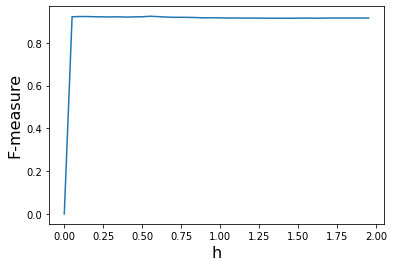

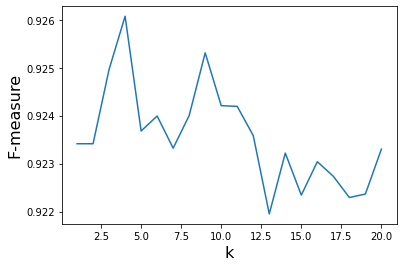

best f-measure:  0.9236796724757479


In [316]:

plt.plot(f_from_h[0], f_from_h[1])
plt.ylabel('F-measure', fontsize=16)
plt.xlabel('h', fontsize=16)
plt.show()
plt.plot(f_from_k[0], f_from_k[1])
plt.ylabel('F-measure', fontsize=16)
plt.xlabel('k', fontsize=16)
plt.show()
print('best f-measure: ', f_from_k[1][np.where(f_from_k[0] == 5)[0][0]])